# CIFAR-10 CNN for Kids (real CNN, friendly explanations)

This notebook teaches how a **CNN (Convolutional Neural Network)** learns to recognize **tiny color photos** from the **CIFAR-10** dataset.

CIFAR-10 has **10 classes**:
- airplane, automobile, bird, cat, deer,
- dog, frog, horse, ship, truck

Each image is:
- **32×32 pixels**
- **3 channels** (Red, Green, Blue) → we write this as `(32, 32, 3)`

You'll learn:
- What **shape** means
- What **RGB channels** are
- What **convolution kernels/filters** are
- Why we use **pooling**
- Why we use **dropout**
- How to build/train a CNN in **TensorFlow / Keras**
- How to select a test image and predict it

## 0) Install / Imports

If you're in Google Colab, TensorFlow is usually installed.

If running locally (terminal):

```bash
pip install tensorflow matplotlib numpy ipywidgets
```

Now we import libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## 1) Load CIFAR-10

CIFAR-10 is built into Keras.

- `x_train` has 50,000 images
- `x_test` has 10,000 images
- Each image is `32×32×3` (RGB)

Labels are numbers 0..9, but we also have class names.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("x_train shape:", x_train.shape)  # (50000, 32, 32, 3)
print("y_train shape:", y_train.shape)  # (50000, 1)
print("x_test shape :", x_test.shape)   # (10000, 32, 32, 3)
print("y_test shape :", y_test.shape)   # (10000, 1)

# Turn labels from shape (N,1) into (N,) so it's easier to use
y_train = y_train.squeeze()
y_test = y_test.squeeze()

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
print("Classes:", class_names)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape : (10000, 32, 32, 3)
y_test shape : (10000, 1)
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### What does shape `(32, 32, 3)` mean?

Think of an image like a stack of 3 pictures:

- Red layer (how much red)
- Green layer (how much green)
- Blue layer (how much blue)

So each pixel actually has 3 numbers: `(R, G, B)`.

That’s why the shape is `(height, width, channels)` → `(32, 32, 3)`.

One image shape: (32, 32, 3)
Label number: 6 -> class name: frog


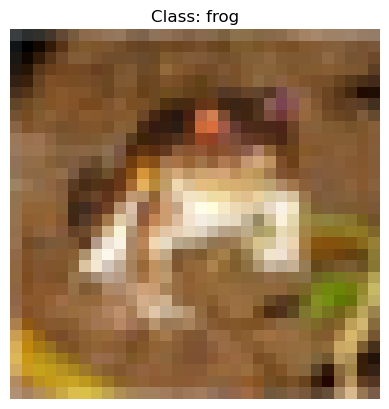

Pixel min: 0 Pixel max: 255


In [3]:
# Show one example image
i = 0
img = x_train[i]
label = y_train[i]

print("One image shape:", img.shape)
print("Label number:", label, "-> class name:", class_names[label])

plt.imshow(img)
plt.title(f"Class: {class_names[label]}")
plt.axis("off")
plt.show()

# Show RGB channel ranges
print("Pixel min:", img.min(), "Pixel max:", img.max())

## 2) Preprocess the data (normalize)

Pixels are 0..255.
Neural networks usually learn better with smaller numbers.

So we scale to **0..1** by dividing by 255.

(We do NOT need to add a channel dimension here because CIFAR already has 3 channels.)

In [4]:
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

print("After scaling:")
print("x_train min/max:", x_train.min(), x_train.max())
print("x_train shape:", x_train.shape)

After scaling:
x_train min/max: 0.0 1.0
x_train shape: (50000, 32, 32, 3)


## 3) Convolution idea (kid story + real detail)

Imagine each filter is a **tiny detective** with a **3×3 magnifying glass**.

The detective slides the magnifying glass over the picture.
At each spot, it asks: “Do I see my favorite pattern here?”
- maybe a tiny edge
- maybe a curve
- maybe a texture

Each filter produces a new image called a **feature map**:
- bright spots = “I found my pattern!”
- dark spots = “Not here.”

### Kernel shape (technical)
For CIFAR RGB images, a Conv2D kernel has shape:

`(kernel_height, kernel_width, input_channels) = (3, 3, 3)`

Because input_channels = 3 (R,G,B).

In [5]:
# Example: just showing what kernel shape means (we won't hand-convolve RGB here)
kernel_h, kernel_w, channels = 3, 3, 3
print("A typical CIFAR Conv2D kernel shape would be:", (kernel_h, kernel_w, channels))

A typical CIFAR Conv2D kernel shape would be: (3, 3, 3)


## 4) Pooling (shrinking smartly)

MaxPooling(2×2) looks at each 2×2 square and keeps the biggest number.

- It shrinks width/height by 2
- It keeps strong signals
- It makes training faster and often helps generalization

Example:
- 32×32 becomes 16×16 after one pooling layer
- 16×16 becomes 8×8 after another pooling layer

## 5) Dropout (anti-memorizing)

Dropout randomly turns off some neurons during training.

That stops the model from memorizing the training set like a “cheat sheet”
and helps it learn real patterns.

## 6) Build a simple CNN for CIFAR-10

We'll build a small CNN:

1. Conv2D + ReLU
2. MaxPooling
3. Conv2D + ReLU
4. MaxPooling
5. Dropout
6. Flatten
7. Dense + ReLU
8. Dropout
9. Dense(10) + softmax

### Why softmax?
Softmax turns the final 10 numbers into probabilities that add up to 1.
So the model can say things like:
- cat: 0.70
- dog: 0.20
- ship: 0.05
- ...

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2,2)),  # 32x32 -> 16x16

    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2,2)),  # 16x16 -> 8x8

    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

## 7) Train the CNN

CIFAR-10 is harder than MNIST, so training can take longer.
We’ll train for a few epochs for learning/demo.

You can increase epochs if you want better accuracy.

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.6702 - loss: 0.9312 - val_accuracy: 0.6886 - val_loss: 0.9041
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6987 - loss: 0.8447 - val_accuracy: 0.7071 - val_loss: 0.8469
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7165 - loss: 0.7941 - val_accuracy: 0.7080 - val_loss: 0.8466
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.7369 - loss: 0.7393 - val_accuracy: 0.7113 - val_loss: 0.8419
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7478 - loss: 0.7029 - val_accuracy: 0.7111 - val_loss: 0.8600
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7592 - loss: 0.6698 - val_accuracy: 0.7019 - val_loss: 0.8980
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.7676 - loss: 0.6406 - val_accuracy: 0.7117 - val_loss: 0.8798
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7806 -

## 8) Training history graphs (loss + accuracy)

- Loss down = better
- Accuracy up = better
- Validation helps you see if it's overfitting

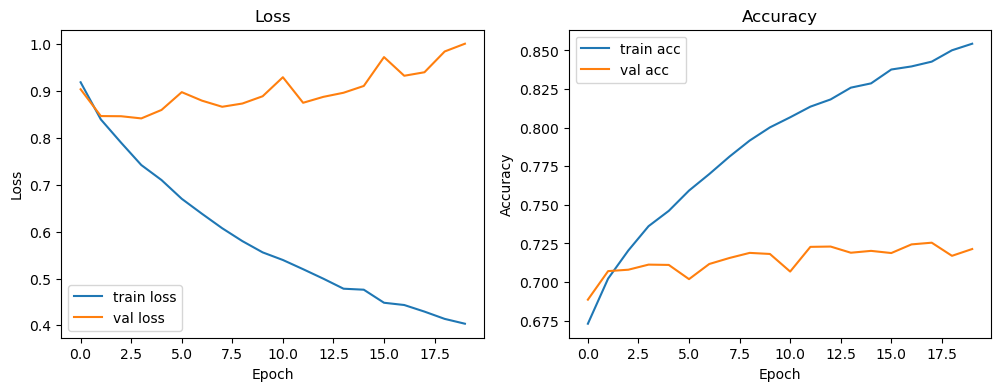

In [13]:
hist = history.history

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(hist["loss"], label="train loss")
plt.plot(hist["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(hist["accuracy"], label="train acc")
plt.plot(hist["val_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

## 9) Evaluate on test set

Now we test on images the model never saw during training.

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy:", float(test_acc))
print("Test loss    :", float(test_loss))

Test accuracy: 0.7113999724388123
Test loss    : 1.0340455770492554


## 10) Predict ONE test image

The model outputs 10 probabilities (one per class).
We take the biggest probability as the predicted class.

True: 3 -> cat
Pred: 3 -> cat


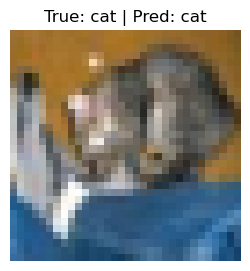

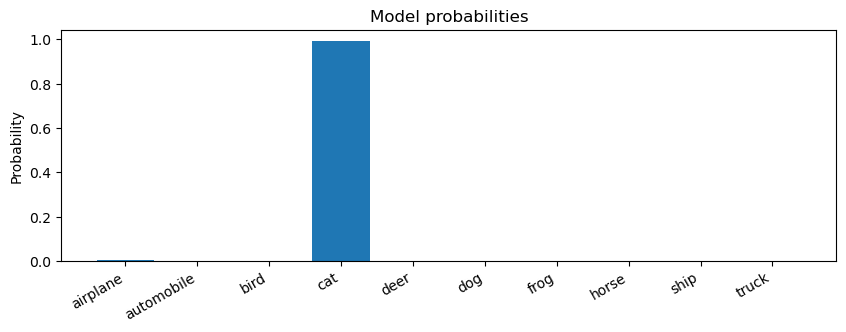

In [15]:
idx = 0
img = x_test[idx]
true_label = int(y_test[idx])

probs = model.predict(img[None, ...], verbose=0)[0]
pred_label = int(np.argmax(probs))

print("True:", true_label, "->", class_names[true_label])
print("Pred:", pred_label, "->", class_names[pred_label])

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.title(f"True: {class_names[true_label]} | Pred: {class_names[pred_label]}")
plt.axis("off")
plt.show()

plt.figure(figsize=(10,3))
plt.bar(class_names, probs)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Probability")
plt.title("Model probabilities")
plt.show()

## 11) Select another image and predict (interactive)

If `ipywidgets` works in your notebook:
- you get a slider to select any test image index
- you see the prediction update

If widgets are not available:
- change `idx = ...` in manual mode.

In [11]:
def show_prediction(idx: int):
    img = x_test[idx]
    true_label = int(y_test[idx])

    probs = model.predict(img[None, ...], verbose=0)[0]
    pred_label = int(np.argmax(probs))

    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(f"Index {idx}\nTrue: {class_names[true_label]} | Pred: {class_names[pred_label]}")
    plt.axis("off")
    plt.show()

    # Show probabilities
    top = np.argsort(probs)[::-1][:5]
    print("Top 5 guesses:")
    for k in top:
        print(f"  {class_names[k]:10s}: {probs[k]:.3f}")

    plt.figure(figsize=(10,3))
    plt.bar(class_names, probs)
    plt.xticks(rotation=30, ha="right")
    plt.ylim(0, 1)
    plt.ylabel("Probability")
    plt.title("Probabilities")
    plt.show()

try:
    import ipywidgets as widgets
    from IPython.display import display

    slider = widgets.IntSlider(value=0, min=0, max=len(x_test)-1, step=1, description="Test idx:")
    ui = widgets.interactive_output(show_prediction, {"idx": slider})
    display(slider, ui)

except Exception as e:
    print("ipywidgets not available here. Manual mode works!")
    idx = 123
    show_prediction(idx)

IntSlider(value=0, description='Test idx:', max=9999)

Output()

# Quick quiz (check understanding)

1. CIFAR images have shape `(32, 32, 3)`. What does the `3` mean?
2. Why do we divide pixel values by 255?
3. What is a convolution filter (kernel) like in real life?
4. What does MaxPooling do (in one sentence)?
5. Why do we use Dropout?
6. Why does the final layer have **10** outputs and use **softmax**?